In [1]:
from smart_open import smart_open
import pandas as pd
import numpy as np
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import logging
%matplotlib inline
from itertools import islice
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\Piboditheowl\Anaconda2\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Piboditheowl\Anaconda2\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
%%time 
wv = Word2Vec.load_word2vec_format(
    "GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

2016-11-03 16:29:07,569 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2016-11-03 16:31:00,035 : INFO : loaded (3000000L, 300L) matrix from GoogleNews-vectors-negative300.bin.gz
2016-11-03 16:31:00,036 : INFO : precomputing L2-norms of word weight vectors


Wall time: 2min 7s


### Функции для обработки данных

In [3]:
def tokenize_text(text): #токенизируем текст
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [4]:
def clean_df(df, x=1, y=15): 
    #Чистим изначальный массив, берем определенное количество спикеров, по частоте их выступлений
    
    ind = df.Speaker.value_counts()[x:y].index # берем имена спикеров
        
    new_df=df[df.Speaker==ind[0]] # первый элемент дата фрейма 
    for i in range(1,len(ind)): # проходим по остальным элементам
        new_df=pd.concat([new_df,df[df.Speaker==ind[i]]]) # добавляем последующие подмассивы в основной

    return new_df # выводим

### Считываем и чистим данные

In [5]:
data = pd.read_csv('primary_debates_cleaned.csv') #считываем текст
df = clean_df(data) #чистим
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42) #разбиваем на выборки

In [382]:
ramil = pd.read_csv("ramil.csv",sep=';') # как независисый приме возmvмем ряд текстов независимых

### Токенизируем

In [302]:
train_tagged = train_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Speaker]), axis=1) #токенизируем+ставим тэг на каждый текст по спикеру
test_tagged = test_data.apply(lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Speaker]), axis=1) #токенизируем+ ставим тэг на каждый текст по спикеру

In [383]:
tokramil = ramil.apply(lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Unknown]), axis=1)

In [304]:
trainsent = train_tagged.values # сохраняем значения текст разбитый на слова и спикера
testsent = test_tagged.values # сохраняем значения текст разбитый на слова и спикера

In [385]:
ramilsent = tokramil.values

### Тренируем модель

In [352]:
doc2vec_model = Doc2Vec(trainsent, workers=4, size=150, iter=10, dm=1) #обучаем модель кличество слов итераций и тп


2016-11-03 17:55:00,841 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2016-11-03 17:55:00,841 : INFO : collecting all words and their counts
2016-11-03 17:55:00,841 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2016-11-03 17:55:00,917 : INFO : collected 9466 word types and 14 unique tags from a corpus of 5691 examples and 266029 words
2016-11-03 17:55:00,917 : INFO : Loading a fresh vocabulary
2016-11-03 17:55:00,928 : INFO : min_count=5 retains 3238 unique words (34% of original 9466, drops 6228)
2016-11-03 17:55:00,933 : INFO : min_count=5 leaves 255279 word corpus (95% of original 266029, drops 10750)
2016-11-03 17:55:00,944 : INFO : deleting the raw counts dictionary of 9466 items
2016-11-03 17:55:00,944 : INFO : sample=0 downsamples 0 most-common words
2016-11-03 17:55:00,948 : INFO : downsampling leaves estimated 255279 word corpus (100.0% of prior 255279)
2016-11-03 17:55:00,948 : INFO : estimated required me

### Превращаем все в вектора согласно весам модели

In [374]:
train_targets, train_regressors = zip(                                                
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=5)) for doc in trainsent]) #векторизуем
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=5)) for doc in testsent])

In [409]:
ram_targets, ram_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=5)) for doc in ramilsent])

### Описываем функцию оценки

In [356]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

### Визуализируем

In [357]:
from sklearn.metrics import accuracy_score, confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap="cool"):
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [406]:
logreg = linear_model.LogisticRegression(n_jobs=20, C=1e5) ### определяем регрессию


accuracy 0.529225908373
confusion matrix
 [[ 5  4  1  0  3  4  1  0  0  0  4  2  2  1]
 [ 0 23  0  0  0  3  0  0  0  0  0  1  9  0]
 [ 0  0 10  0  0  1  1  1  1  0  3  0  0  3]
 [ 0  0  0 32  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  3  0 34  0  0  2  0  2  6 11  2  9]
 [ 1  5  0  0  0 10  0  0  1  0  1  1  7  1]
 [ 1  1  0  0  5  0 21  2  0  0  2  5  0  7]
 [ 0  2  3  0  4  0  3 11  1  0  3  1  1  5]
 [ 0  7  2  0  1  1  1  0  3  0  1  1  2  4]
 [ 0  0  0  0  0  0  0  0  0 40  0  0  0  0]
 [ 0  0  2  0  6  0 13  1  2  0 15  3  1 11]
 [ 1  1  3  0  6  2  6  1  0  0  1 51  1 13]
 [ 1  7  0  0  0  2  4  0  2  0  0  0 18  0]
 [ 0  4  2  0  9  4  3  0  2  0  4 14  2 62]]
(row=expected, col=predicted)


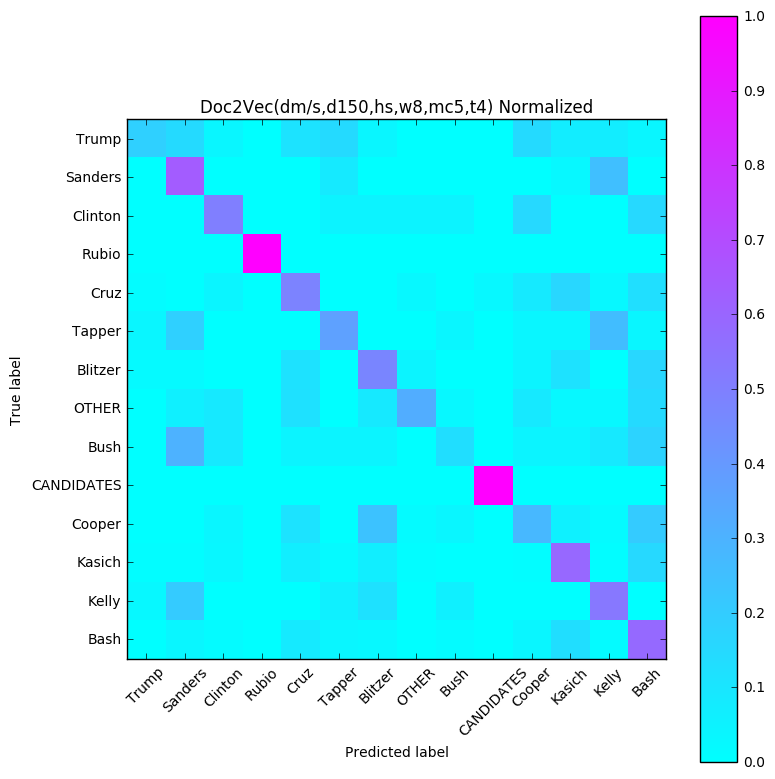

In [407]:
logreg = logreg.fit(train_regressors, train_targets) ### учим регрессию
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model)) ###оцениваем результаты


In [410]:
reg = logreg.predict(ram_regressors)
reg

array(['Trump', 'Sanders', 'Trump', 'Clinton', 'Trump', 'Sanders', 'Trump',
       'Clinton', 'Trump', 'Cruz', 'Trump', 'Clinton', 'Trump', 'Cruz',
       'Trump', 'Clinton', 'Clinton'], 
      dtype='|S10')

In [411]:
v = np.asarray(train_regressors)
v=pd.DataFrame(v)
df.to_csv('class.csv', index=None)